# MSDS 7331 - Lab 3 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

#### The dataset chosen is a compilation of airline customer satisfaction surveys.  The goal is to select from one of features (Association Rule Mining, Clustering, or Collaborative Filtering) to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed) to help us understand the customer sastification. 

Source: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=test.csv

In [178]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

# Import Cluster Analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import scipy.cluster.hierarchy as sch

#import visualization libraries
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

***
### Data Understanding (20 points total)
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [179]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()

#reduced samples set from 100,000 to 30,000 as a few of us had computer performance issues
df = df.sample(n=30000)

#### Check for NAs


In [180]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.")

Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [181]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)

df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [182]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [183]:
dfclean.describe().T

count         mean         std   min  \
Age                                30000.0    39.409300   15.112427   7.0   
Flight Distance                    30000.0  1191.714167  995.864776  31.0   
Inflight wifi service              30000.0     2.723233    1.323112   0.0   
Departure/Arrival time convenient  30000.0     3.060367    1.522213   0.0   
Ease of Online booking             30000.0     2.749600    1.394118   0.0   
Gate location                      30000.0     2.973200    1.277942   1.0   
Food and drink                     30000.0     3.200867    1.329754   0.0   
Online boarding                    30000.0     3.246600    1.348079   0.0   
Seat comfort                       30000.0     3.441600    1.322188   1.0   
Inflight entertainment             30000.0     3.358467    1.335950   0.0   
On-board service                   30000.0     3.385300    1.283731   1.0   
Leg room service                   30000.0     3.343533    1.315716   0.0   
Baggage handling                   30000.0     3.633200    1.181315   1.0   
Checkin service                    30000.0     3.307333    1.267333   1.0   
Inflight service                   30000.0     3.644733    1.175003   1.0   
Cleanliness                        30000.0     3.294033    1.316296   0.0   
Departure Delay in Minutes         30000.0    14.896900   37.857350   0.0   
Arrival Delay in Minutes           30000.0    15.186733   38.119385   0.0   
GenderNumeric                      30000.0     0.487667    0.499856   0.0   
CustomerTypeNumeric                30000.0     0.819267    0.384803   0.0   
TypeofTravelNumeric                30000.0     0.313100    0.463762   0.0   
ClassNumeric                       30000.0     1.028867    0.962184   0.0   

                                     25%    50%     75%     max  
Age                                 27.0   40.0    51.0    85.0  
Flight Distance                    416.0  845.0  1744.0  4983.0  
Inflight wifi service                2.0    3.0     4.0     5.0  
Departure/Arrival time convenient    2.0    3.0     4.0     5.0  
Ease of Online booking               2.0    3.0     4.0     5.0  
Gate location                        2.0    3.0     4.0     5.0  
Food and drink                       2.0    3.0     4.0     5.0  
Online boarding                      2.0    3.0     4.0     5.0  
Seat comfort                         2.0    4.0     5.0     5.0  
Inflight entertainment               2.0    4.0     4.0     5.0  
On-board service                     2.0    4.0     4.0     5.0  
Leg room service                     2.0    4.0     4.0     5.0  
Baggage handling                     3.0    4.0     5.0     5.0  
Checkin service                      3.0    3.0     4.0     5.0  
Inflight service                     3.0    4.0     5.0     5.0  
Cleanliness                          2.0    3.0     4.0     5.0  
Departure Delay in Minutes           0.0    0.0    12.0  1017.0  
Arrival Delay in Minutes             0.0    0.0    13.0  1011.0  
GenderNumeric                        0.0    0.0     1.0     1.0  
CustomerTypeNumeric                  1.0    1.0     1.0     1.0  
TypeofTravelNumeric                  0.0    0.0     1.0     1.0  
ClassNumeric                         0.0    1.0     2.0     2.0

In [184]:
dfclean.corr()

Age  Flight Distance  \
Age                                1.000000         0.103144   
Flight Distance                    0.103144         1.000000   
Inflight wifi service              0.011605         0.001464   
Departure/Arrival time convenient  0.031616        -0.024588   
Ease of Online booking             0.014329         0.062980   
Gate location                     -0.004841         0.004318   
Food and drink                     0.017491         0.055447   
Online boarding                    0.201382         0.212269   
Seat comfort                       0.157772         0.153750   
Inflight entertainment             0.072965         0.126709   
On-board service                   0.051403         0.109920   
Leg room service                   0.035209         0.136344   
Baggage handling                  -0.049591         0.062211   
Checkin service                    0.038254         0.073987   
Inflight service                  -0.054481         0.057834   
Cleanliness                        0.052751         0.090612   
Departure Delay in Minutes        -0.007555         0.005244   
Arrival Delay in Minutes          -0.010538         0.001375   
GenderNumeric                      0.013949         0.006317   
CustomerTypeNumeric                0.276482         0.221792   
TypeofTravelNumeric               -0.048492        -0.271513   
ClassNumeric                       0.138452         0.453258   

                                   Inflight wifi service  \
Age                                             0.011605   
Flight Distance                                 0.001464   
Inflight wifi service                           1.000000   
Departure/Arrival time convenient               0.344461   
Ease of Online booking                          0.716846   
Gate location                                   0.338113   
Food and drink                                  0.129381   
Online boarding                                 0.456895   
Seat comfort                                    0.121447   
Inflight entertainment                          0.212787   
On-board service                                0.118031   
Leg room service                                0.152218   
Baggage handling                                0.118930   
Checkin service                                 0.037827   
Inflight service                                0.106462   
Cleanliness                                     0.130695   
Departure Delay in Minutes                     -0.014544   
Arrival Delay in Minutes                       -0.018279   
GenderNumeric                                   0.002575   
CustomerTypeNumeric                             0.005197   
TypeofTravelNumeric                            -0.103725   
ClassNumeric                                    0.032146   

                                   Departure/Arrival time convenient  \
Age                                                         0.031616   
Flight Distance                                            -0.024588   
Inflight wifi service                                       0.344461   
Departure/Arrival time convenient                           1.000000   
Ease of Online booking                                      0.436766   
Gate location                                               0.440144   
Food and drink                                             -0.000853   
Online boarding                                             0.066121   
Seat comfort                                                0.010124   
Inflight entertainment                                     -0.006642   
On-board service                                            0.068341   
Leg room service                                            0.008952   
Baggage handling                                            0.068891   
Checkin service                                             0.094059   
Inflight service                                            0.075450   
Cleanliness                       

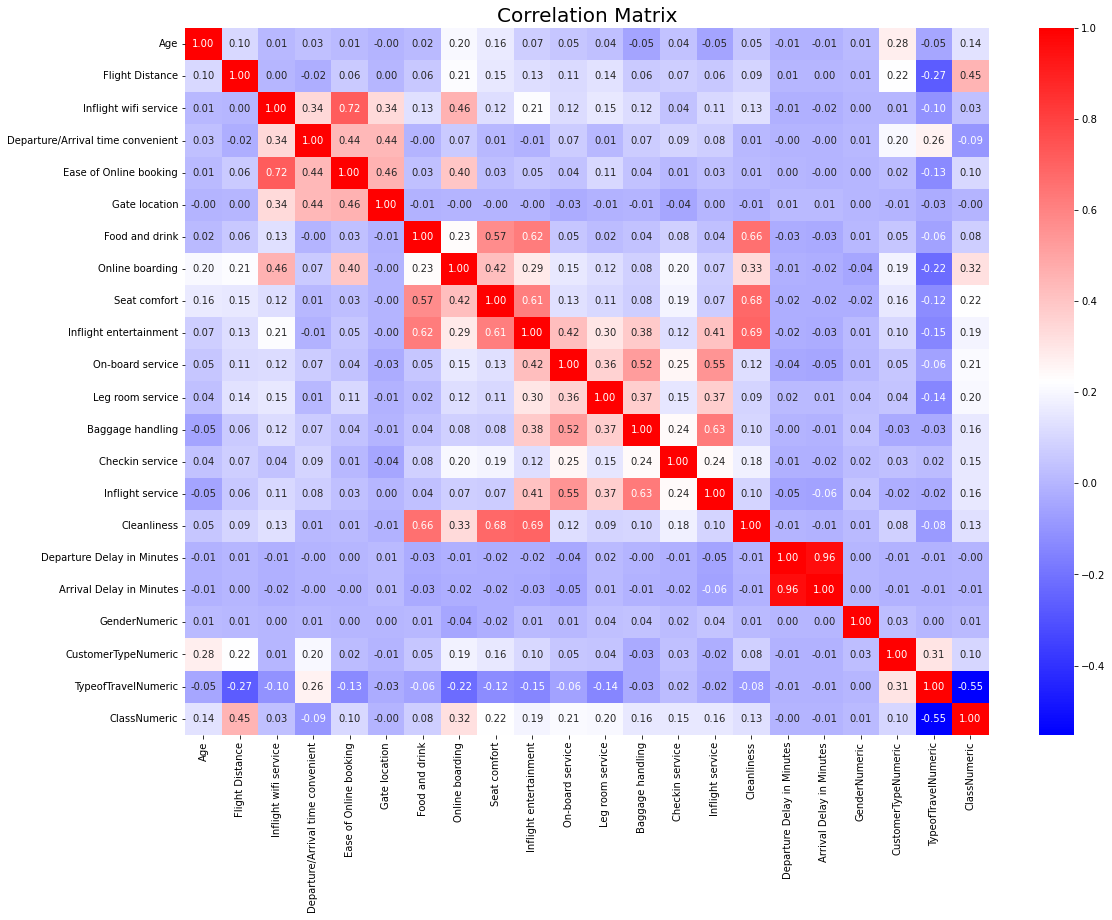

In [185]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="bwr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



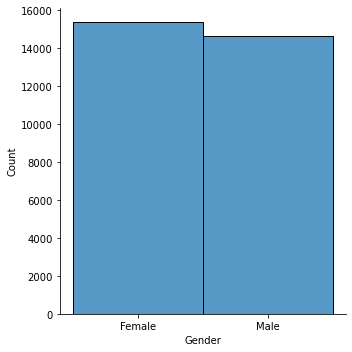

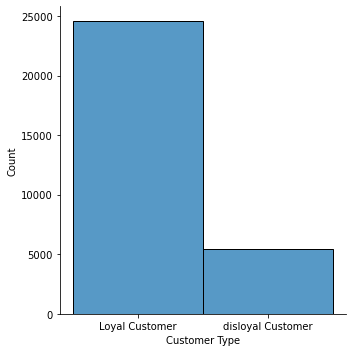

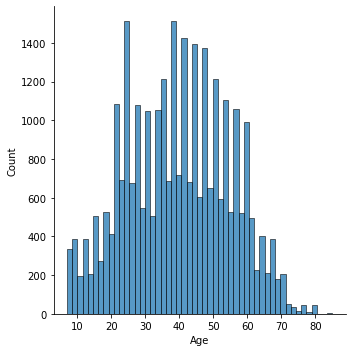

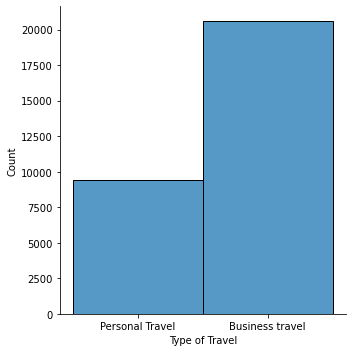

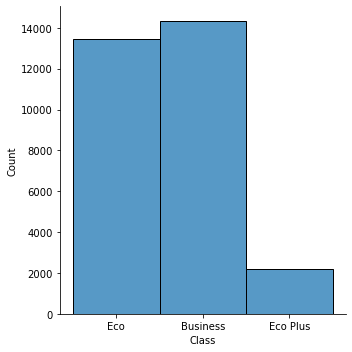

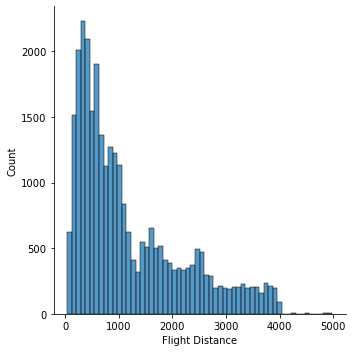

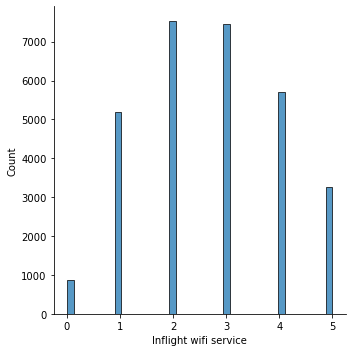

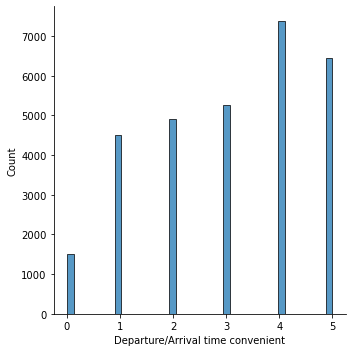

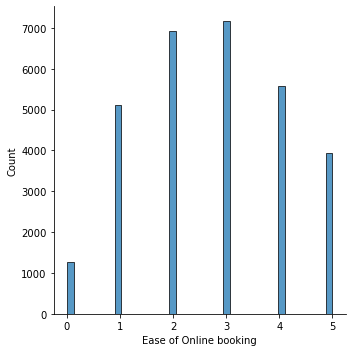

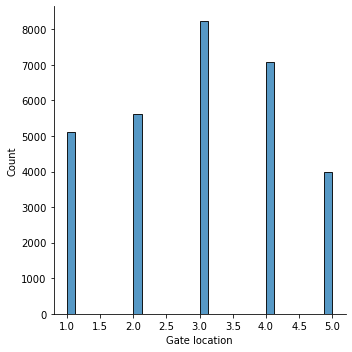

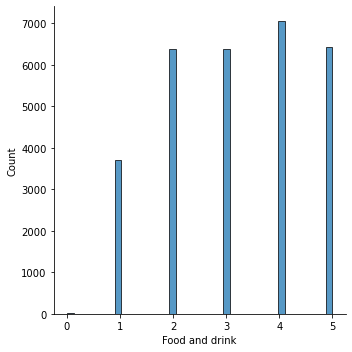

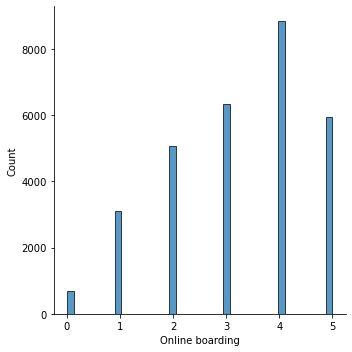

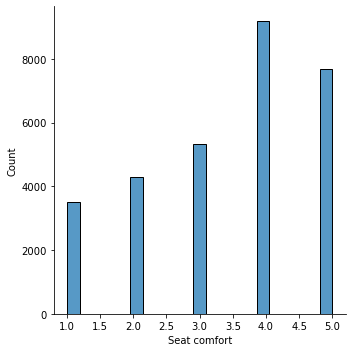

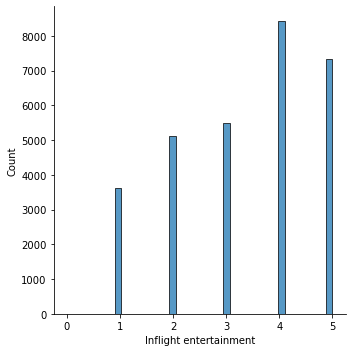

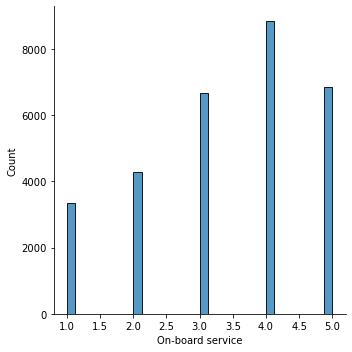

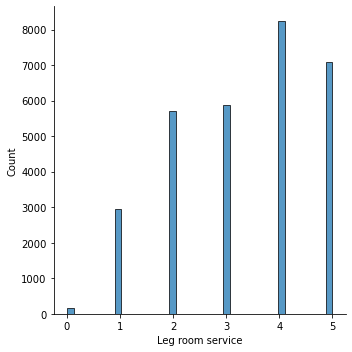

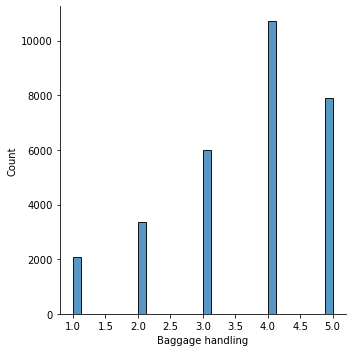

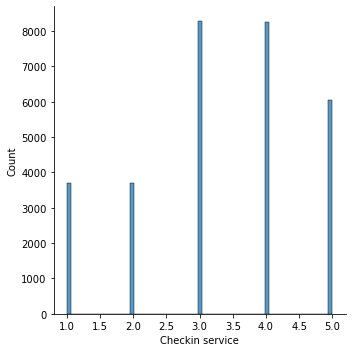

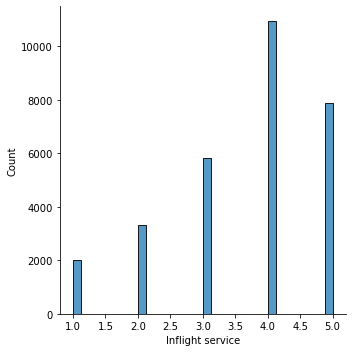

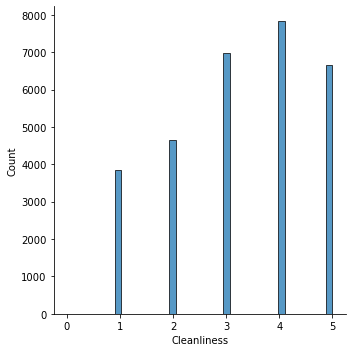

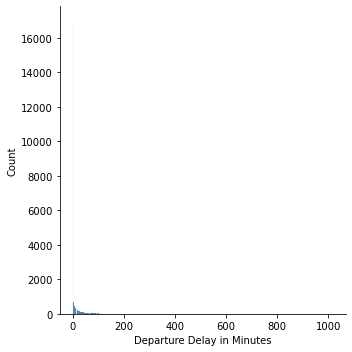

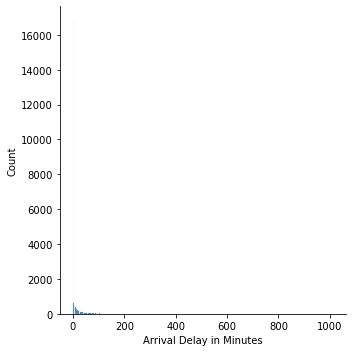

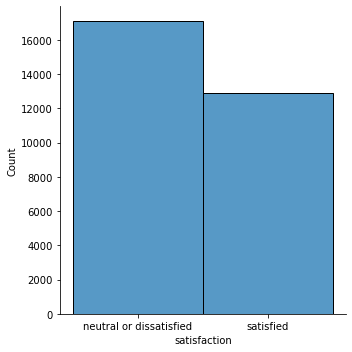

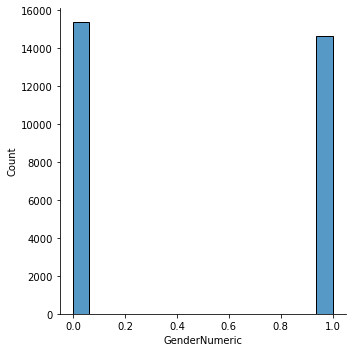

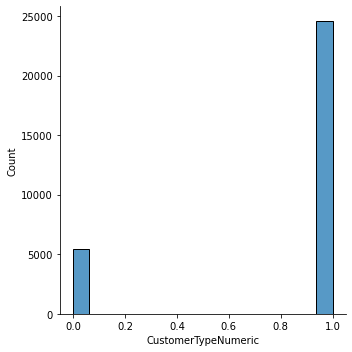

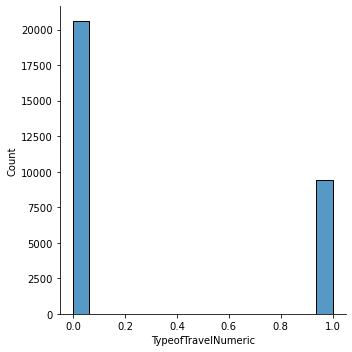

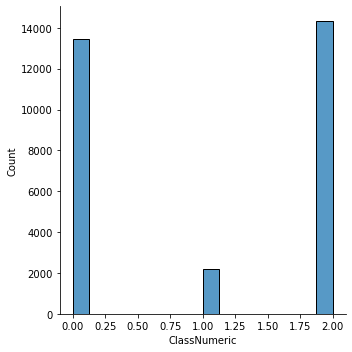

In [186]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

In [187]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 6669 to 45762
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             30000 non-null  object 
 1   Customer Type                      30000 non-null  object 
 2   Age                                30000 non-null  int64  
 3   Type of Travel                     30000 non-null  object 
 4   Class                              30000 non-null  object 
 5   Flight Distance                    30000 non-null  int64  
 6   Inflight wifi service              30000 non-null  int64  
 7   Departure/Arrival time convenient  30000 non-null  int64  
 8   Ease of Online booking             30000 non-null  int64  
 9   Gate location                      30000 non-null  int64  
 10  Food and drink                     30000 non-null  int64  
 11  Online boarding                    30000 non-null  

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

*** 
### [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [188]:
 #Sum Survey Score Columns - index(6:19)
dfclean['Survey_Total']=dfclean.iloc[:,6:19].sum(axis=1)

#Add Age Groups
dfclean['Age_Group'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["Adolescent", "Young Adult", "Middle Age", "Senior"], right=True)
dfclean['Age_Group_Numeric'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["1", "2", "3", "4"], right=True)

#Add Distance Groups
dfclean['Distance_Group'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["Short", "Moderate", "Long", "Extra Long"], right=True)
dfclean['Distance_Group_Numeric'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["1", "2", "3", "4"], right=True)

#Add Departure Delay Groups
dfclean['Departure_Delay_Group'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["None","Minimal","Long"], right=True)
dfclean['Departure_Delay_Group_Numeric'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["0","1","2"], right=True)

#Change Satisfaction to 1 or 0
dfclean['satisfaction'].replace('neutral or dissatisfied', 0,inplace=True)
dfclean['satisfaction'].replace('satisfied', 1,inplace=True)


dfclean.head(n=50)

Gender      Customer Type  Age   Type of Travel     Class  \
6669    Female     Loyal Customer    7  Personal Travel       Eco   
93469   Female     Loyal Customer   34  Business travel  Business   
82036     Male     Loyal Customer   59  Business travel  Business   
12688     Male     Loyal Customer   56  Business travel  Business   
39847     Male     Loyal Customer   49  Business travel  Business   
101259    Male     Loyal Customer   45  Business travel  Business   
16543     Male     Loyal Customer   60  Personal Travel       Eco   
48618   Female     Loyal Customer   15  Personal Travel  Business   
91127   Female  disloyal Customer   16  Business travel       Eco   
93472     Male     Loyal Customer   49  Business travel  Business   
85430     Male     Loyal Customer   48  Business travel  Business   
2275      Male     Loyal Customer   62  Personal Travel       Eco   
101075    Male     Loyal Customer   66  Personal Travel       Eco   
36840     Male  disloyal Customer   26  Business travel       Eco   
97258     Male     Loyal Customer   13  Personal Travel       Eco   
717       Male     Loyal Customer   32  Business travel  Business   
87393   Female     Loyal Customer   44  Business travel  Business   
99360   Female     Loyal Customer   52  Business travel  Business   
25751   Female     Loyal Customer   35  Business travel  Business   
21576     Male     Loyal Customer   33  Personal Travel       Eco   
70480     Male     Loyal Customer   61  Business travel  Eco Plus   
94551     Male     Loyal Customer   56  Business travel       Eco   
67975   Female     Loyal Customer   50  Business travel       Eco   
195       Male     Loyal Customer   45  Personal Travel       Eco   
51236   Female     Loyal Customer   21  Business travel       Eco   
64938   Female     Loyal Customer   62  Business travel  Business   
11119   Female  disloyal Customer   25  Business travel       Eco   
51455     Male     Loyal Customer   33  Business travel  Business   
93524   Female  disloyal Customer   21  Business travel       Eco   
72950   Female     Loyal Customer   56  Business travel  Business   
13433     Male     Loyal Customer   59  Business travel       Eco   
43390     Male  disloyal Customer   29  Business travel  Business   
87289     Male     Loyal Customer   14  Business travel  Business   
84076     Male  disloyal Customer   18  Business travel       Eco   
101991  Female     Loyal Customer   27  Business travel  Eco Plus   
62094   Female  disloyal Customer   25  Business travel  Business   
7004      Male     Loyal Customer   41  Personal Travel  Eco Plus   
72317   Female     Loyal Customer    8  Personal Travel       Eco   
64140   Female     Loyal Customer   27  Business travel  Eco Plus   
31098   Female     Loyal Customer   57  Personal Travel       Eco   
69107     Male     Loyal Customer   70  Personal Travel       Eco   
12771   Female     Loyal Customer   45  Business travel  Business   
69951   Female     Loyal Customer   43  Business travel  Business   
72049     Male     Loyal Customer   49  Personal Travel       Eco   
89798   Female     Loyal Customer   41  Personal Travel       Eco   
79423   Female     Loyal Customer   46  Business travel  Business   
36081   Female     Loyal Customer   19  Personal Travel       Eco   
25122   Female     Loyal Customer   51  Business travel  Business   
7677      Male     Loyal Customer   69  Personal Travel       Eco   
13432     Male  disloyal Customer   29  Business travel  Business   

        Flight Distance  Inflight wifi service  \
6669                309                      2   
93469              2049                      4   
82036              1166                      4   
12688              3836                      1   
39847              1726                      3   
101259             2902                      4   
16543               239                      1   
48618              1235                      1   
91127              1892               

In [189]:
#Plotly Histogram - Age
px.histogram(dfclean['Age'], x= "Age",
             title = 'Age Distribution',
             )

In [190]:
#Plotly Histogram - Flight Distance
px.histogram(dfclean['Flight Distance'], x= "Flight Distance",
             title = 'Flight Distance Distribution',
             )

In [191]:
#Plotly Histogram - Departure Delay in Minutes
px.histogram(dfclean['Departure Delay in Minutes'], x= "Departure Delay in Minutes",
             title = 'Departure Delay Distribution',
             nbins = 50,
             )

In [192]:
#Plotly Histogram - Arrival Delay in Minutes
px.histogram(dfclean['Arrival Delay in Minutes'], x= "Arrival Delay in Minutes",
             title = 'Arrival Delay Distribution',
             nbins = 50,
             )

In [193]:
px.box(dfclean,
       x="Class", y="Age", 
       color="Class",
       title = "Box Plot of Age by Class")

In [194]:
#ANOVA of class to age
# Ordinary Least Squares (OLS) model
model = ols('Age ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Class)  1.335335e+05      2.0  298.133682  6.197783e-129
Residual  6.717802e+06  29997.0         NaN            NaN

The ANOVA between age and class shows overwhelming evidence that there is a difference between the mean age of travelers among the various classes.

In [195]:
px.box(dfclean,
       x="Class", y="Survey_Total", 
       color="Class",
       title = "Box Plot of Survey Total by Class")

In [196]:
#ANOVA of Class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df            F  PR(>F)
C(Class)  1.601654e+05      2.0  1184.380774     0.0
Residual  2.028267e+06  29997.0          NaN     NaN

The ANOVA between class and survey score shows overwhelming evidence that there is a difference between the mean survey score among the classes.

In [197]:
px.box(dfclean,
       x="Distance_Group", y="Survey_Total", 
       color="Distance_Group",
       title = "Box Plot of Age by Survey Total")

In [198]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Distance_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Distance_Group)  4.840033e+04      3.0  226.136253  4.365859e-145
Residual           2.140032e+06  29996.0         NaN            NaN

The ANOVA between distance group and survey score shows overwhelming evidence that there is a difference between the mean survey score among the distance groups.

In [199]:
#ANOVA of class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Age)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F         PR(>F)
C(Age)    7.385132e+04     74.0  14.123306  5.286006e-168
Residual  2.114581e+06  29925.0        NaN            NaN

In [200]:
px.box(dfclean,
       x="Departure_Delay_Group", y="Survey_Total", 
       color="Departure_Delay_Group",
       title = "Box Plot of Total by Departure Delay Group")

In [201]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Survey_Total ~ C(Departure_Delay_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F    PR(>F)
C(Departure_Delay_Group)  1.553172e+03      2.0  10.652285  0.000024
Residual                  2.186879e+06  29997.0        NaN       NaN

The ANOVA between departure delay group and survey score shows overwhelming evidence that there is a difference between the mean survey score among the distance groups.

In [202]:
#2 Sample T-Test - Male vs Female

# Subset data
male = dfclean.query('Gender == "Male"')['Survey_Total']
female = dfclean.query('Gender == "Female"')['Survey_Total']

dfclean.groupby('Gender').describe()

Age                                                     \
          count       mean        std  min   25%   50%   75%   max   
Gender                                                               
Female  15370.0  39.203643  15.234550  7.0  27.0  40.0  51.0  85.0   
Male    14630.0  39.625359  14.980534  7.0  28.0  40.0  51.0  85.0   

       Flight Distance               ... ClassNumeric      Survey_Total  \
                 count         mean  ...          75%  max        count   
Gender                               ...                                  
Female         15370.0  1185.577033  ...          2.0  2.0      15370.0   
Male           14630.0  1198.161722  ...          2.0  2.0      14630.0   

                                                           
             mean       std   min   25%   50%   75%   max  
Gender                                                     
Female  41.915485  8.616916  15.0  36.0  42.0  48.0  65.0  
Male    42.228298  8.458022  14.0  36.0  42.0  48.0  65.0  

[2 rows x 192 columns]

In [203]:
#Check normality assumption

#Plotly Histogram - Total
px.histogram(dfclean, x= "Survey_Total",
             title = 'Survey Total Distribution',
             facet_col="Gender"
             )

In [204]:
#Check Variance Assumptions
stats.levene(male, female)

LeveneResult(statistic=8.584684963764518, pvalue=0.0033925740531664103)

In [205]:
#T-Test
res = stats.ttest_ind(male, female, equal_var=True)

display(res)

Ttest_indResult(statistic=3.171290930549218, pvalue=0.0015191579576819421)

***
### Modeling and Evaluation (50 points total) Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. 



#### Option A: Cluster Analysis
- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

In [21]:
#set data to be ready for cluster analysis
cluster_df = dfclean.copy()

continuous_features = ['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']

# and the oridnal values to be integers
ordinal_features = ['Age','Inflight wifi service','Departure/Arrival time convenient']

# we won't touch these variables, keep them as categorical
categ_features = ['GenderNumeric','TypeofTravelNumeric','CustomerTypeNumeric'];

# use the "astype" function to change the variable type
cluster_df[continuous_features] = cluster_df[continuous_features].astype(np.float64)
cluster_df[ordinal_features] = cluster_df[ordinal_features].astype(np.int64)
cluster_df = cluster_df.drop(['Age Group','Distance Group','Gender','Customer Type','Type of Travel', 'Class','satisfaction'], axis=1)


cluster_df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 41661 to 39875
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                30000 non-null  int64  
 1   Flight Distance                    30000 non-null  float64
 2   Inflight wifi service              30000 non-null  int64  
 3   Departure/Arrival time convenient  30000 non-null  int64  
 4   Ease of Online booking             30000 non-null  int64  
 5   Gate location                      30000 non-null  int64  
 6   Food and drink                     30000 non-null  int64  
 7   Online boarding                    30000 non-null  int64  
 8   Seat comfort                       30000 non-null  int64  
 9   Inflight entertainment             30000 non-null  int64  
 10  On-board service                   30000 non-null  int64  
 11  Leg room service                   30000 non-null 

In [22]:
#scale values
cluster_df_scaled = StandardScaler().fit(cluster_df).transform(cluster_df.astype(float))

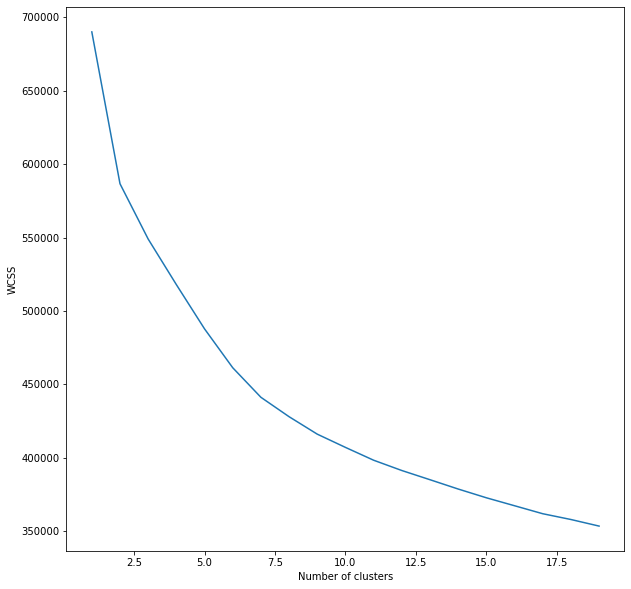

In [23]:
# finding optimal cluster amount
wcss = []
for i in range(1,20):
   model = KMeans(n_clusters = i, init = "k-means++", random_state=67)
   model.fit(cluster_df_scaled)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
# reducing dimensionality
pca = PCA(2)
data = pca.fit_transform(cluster_df_scaled)
data

array([[-0.09704676, -0.14432955],
       [-0.76629842,  3.02484519],
       [-1.93995507,  1.06308126],
       ...,
       [-2.13104933, -2.27874364],
       [-3.10395854, -1.04380683],
       [ 3.02882386, -0.43075345]])

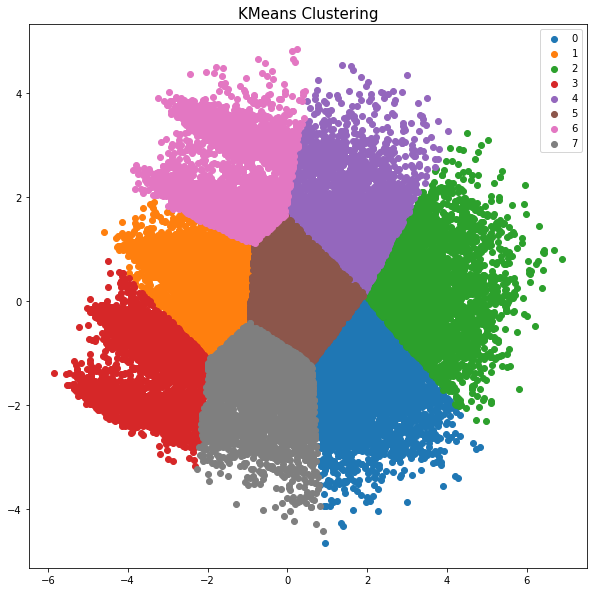

In [25]:
# clustering with PCA components

model = KMeans(n_clusters = 8, init = "k-means++")
label = model.fit_predict(data)


plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('KMeans Clustering', fontsize=15)
plt.show()

In [26]:
metrics.silhouette_score(cluster_df_scaled, label)

0.04945206697650716

### DBSCAN Clustering

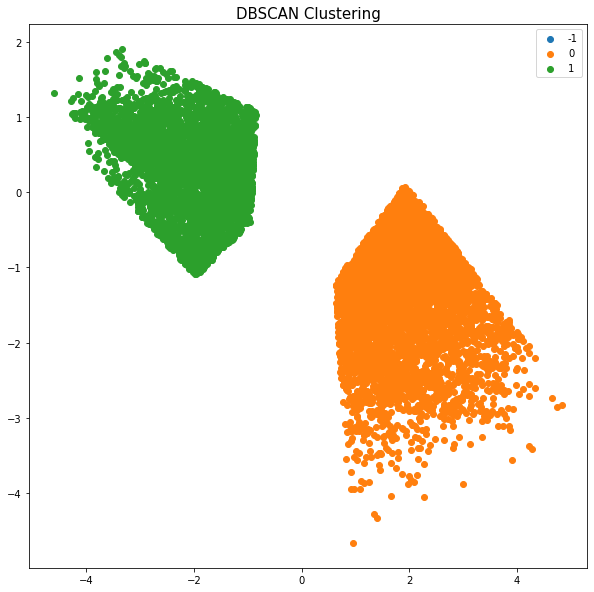

In [35]:
# clustering with PCA components

dbscan = DBSCAN(eps=0.3)
dbscan_label = dbscan.fit_predict(data)

plt.figure(figsize=(10,10))
uniq = np.unique(dbscan_label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('DBSCAN Clustering', fontsize=15)
plt.show()

In [36]:
metrics.silhouette_score(cluster_df_scaled, dbscan_label)

0.15017256646052127

#### Hierarchical Agglomerative Clustering (HAC) Clustering

In [29]:
# utilizing a dendrogram to find the optimal number of clusters

#dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
#plt.title('Dendrogram')
#plt.show()

In [30]:
# hac = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
# hac_label = hac.fit_predict(data)

# plt.figure(figsize=(10,10))
# uniq = np.unique(hac_label)
# for i in uniq:
#    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


# plt.legend()
# plt.title('HAC Clustering', fontsize=15)
# plt.show()

In [31]:
# metrics.silhouette_score(cluster_df_scaled, hac_label)

In [32]:
# result_df = df.copy()
# result_df['kmeans_cluster'] = label
# result_df['dbscan_cluster'] = dbscan_label
# result_df['hac_cluster'] = hac_label
# result_df.info()

### Deployment (10 points total)
- Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

Doug to Bull shit

### Exceptional Work (10 points total)
You have free reign to provide additional analyses or combine analyses

In [34]:
#Exception work above.